# Clustering para Pairs Trading com Ações Brasileiras

## Introdução

Este notebook explora a aplicação de técnicas de *clustering* para selecionar pares de ações brasileiras para uma estratégia de **pairs trading**.

Pairs trading busca explorar **divergências temporárias** nos preços de dois ativos correlacionados, com a suposição de que esses desvios são momentâneos e os preços voltarão à média histórica.

A estratégia envolve:
- Posição **comprada** em um ativo
- Posição **vendida** em outro ativo correlacionado

Essa abordagem reduz a exposição ao risco de mercado, focando no **retorno relativo** dos ativos.

## O Problema da Seleção de Pares

Com n ações, temos \(\frac{n(n-1)}{2}\) pares possíveis. Tradicionalmente, pares eram escolhidos com base em setores ou tentativas manuais. Isso é ineficiente e pode resultar em pares com baixa correlação real.

## Solução: Técnicas de Clustering

Utilizamos três algoritmos principais para agrupar ações com comportamento similar:

- `K-Means`
- `Hierarchical Clustering`
- `Affinity Propagation`

Esses algoritmos identificam agrupamentos (clusters) de ações com **padrões semelhantes de retorno**, facilitando a escolha de pares com comportamento estatístico alinhado.

## Avaliações e Visualizações

O estudo também explora:
- Métodos para **determinar o número ideal de clusters**, como a técnica do **cotovelo** (K-Means) e análise de **dendrogramas** (Hierarchical)
- Visualizações para interpretar melhor os grupos formados

## Variância e Volatilidade

Durante a análise, usamos dois conceitos estatísticos essenciais:

- **Variância**: Mede o grau de dispersão dos retornos em relação à média. Alta variância indica retornos instáveis.
  
- **Volatilidade**: É a raiz quadrada da variância e representa o risco de oscilação dos preços. Usada como medida prática de risco nos mercados financeiros.

Estas métricas ajudam a garantir que os pares dentro de um cluster tenham **comportamentos de risco semelhantes**, tornando a estratégia mais robusta.

---




In [207]:
import warnings
warnings.filterwarnings('ignore')

# Lendo bibliotecas

In [208]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr

#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold



#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

In [209]:
tickers = [
    "B3SA3", "ABEV3", "PETR4", "BEEF3", "VALE3", "BRFS3", "COGN3", "MGLU3", "ITUB4", "BBAS3",
    "PETR3", "BBDC4", "AZTE3", "RADL3", "RAIZ4", "VAMO3", "ITSA4", "BPAC11", "CSAN3", "AZEV4",
    "AZUL4", "CMIG4", "LREN3", "WEGE3", "BHIA3", "POMO4", "VIVT3", "GGBR4", "CPLE6", "ASAI3",
    "BRAV3", "USIM5", "HBOR3", "VBBR3", "PRIO3", "RAIL3", "MRFG3", "CSNA3", "CSMG3", "BBDC3",
    "LWSA3", "CVCB3", "PETZ3", "PCAR3", "ODPV3", "GRND3", "OIBR3", "BBSE3", "RENT3", "GOAU4",
    "MOTV3", "CBAV3", "HAPV3", "UGPA3", "EQTL3", "KLBN11", "RDOR3", "EMBR3", "ENEV3", "CYRE3",
    "TIMS3", "CMIN3", "MOVI3", "GGPS3", "MRVE3", "ARML3", "CPLE3", "ELET3", "TOTS3", "YDUQ3",
    "AURE3", "SIMH3", "AZEV3", "CURY3", "IFCM3", "ANIM3", "ALOS3", "SBSP3", "SMFT3", "IGTI11",
    "RAPT4", "LJQQ3", "BRKM5", "RCSL4", "CXSE3", "CEAB3", "ECOR3", "GMAT3", "FLRY3", "AZZA3",
    "SUZB3", "SANB11", "MULT3", "LIGT3", "RECV3", "BPAN4", "PGMN3", "PSSA3", "PDGR3", "BRAP4",
    "ENGI11", "STBP3", "EGIE3", "HYPE3", "KLBN4", "PORT3", "JHSF3", "HBSA3", "MELK3", "VIVA3",
    "SRNA3", "INTB3", "CASH3", "ISAE4", "CPFE3", "SAPR11", "HBRE3", "POSI3", "ONCO3", "QUAL3",
    "DIRR3", "SMTO3", "SLCE3", "SAPR4", "DXCO3", "SBFG3", "AMER3", "BRSR6", "MDNE3", "TAEE11",
    "KEPL3", "TEND3", "ALUP11", "RANI3", "PLPL3", "ESPA3", "ENJU3", "ELET6", "JALL3", "SEQL3",
    "BMOB3", "TTEN3", "POMO3", "PRNR3", "CAML3", "ALPA4", "NEOE3", "MILS3", "GUAR3", "MYPK3",
    "MDIA3", "EZTC3", "ABCB4", "BLAU3", "BMGB4", "VVEO3", "PMAM3", "JSLG3", "IRBR3", "KLBN3",
    "MLAS3", "FESA4", "VULC3", "EVEN3", "SHUL4", "MEAL3", "TECN3", "SEER3", "PINE4", "TUPY3",
    "ITUB3", "SYNE3", "TCSA3", "MATD3", "BRST3", "CSED3", "PNVL3", "DASA3", "GFSA3", "WIZC3",
    "ORVR3", "SOJA3", "OPCT3", "AALR3", "ZAMP3", "VTRU3", "VLID3", "LOGG3", "VIVR3", "LAVV3",
    "SAPR3", "PTBL3", "MTRE3", "AMAR3", "FRAS3", "PFRM3", "BRBI11", "TRIS3", "FIQE3", "LEVE3",
    "CMIG3", "AGRO3", "ALPK3", "TFCO4", "IGTI3", "TASA4", "TGMA3", "PDTC3", "LOGN3", "TAEE4",
    "RCSL3", "USIM3", "DEXP3", "DESK3", "UNIP6", "AMOB3", "AERI3", "GOAU3", "TAEE3", "VITT3",
    "SCAR3", "ITSA3", "SANB3", "AMBP3", "ROMI3", "CSUD3", "OIBR4", "ALLD3", "ETER3", "DMVF3",
    "UCAS3", "EUCA4", "RNEW4", "SANB4", "BRKM3", "ATED3", "BRAP3", "LUPA3", "WHRL4", "REAG3",
    "GGBR3", "FICT3", "BIOM3", "SHOW3", "EALT4", "INEP3", "ALUP4", "TRAD3", "TPIS3", "FHER3",
    "LPSB3", "RNEW3", "VSTE3", "CAMB3", "HAGA4", "BRSR3", "ENGI4", "AGXY3", "WEST3", "INEP4",
    "RSID3", "AMAR11", "JFEN3", "HOOT4", "BAZA3", "LAND3", "DOTZ3", "BEES3", "BMEB4", "CEBR3",
    "CEDO4", "LVTC3", "BOBR4", "TASA3", "BEES4", "ALUP3", "ENGI3", "DEXP4", "UNIP3", "WLMM4",
    "CEBR6", "BPAC5", "PINE3", "OSXB3", "EQPA3", "PTNT4", "AZEV11", "ALPA3", "ISAE3", "WHRL3",
    "BPAC3", "TELB4", "BIED3", "EMAE4", "OFSA3", "RAPT3", "TELB3", "SNSY5", "MNDL3", "BSLI3",
    "CGAS5", "NGRD3", "EPAR3", "BSLI4", "LUXM4", "NUTR3", "CEEB3", "CTSA3", "EUCA3", "CLSC4",
    "COCE5", "CEBR5", "AVLL3", "MNPR3", "CRPG5", "BALM4", "SNSY3", "GSHP3", "MTSA4", "EALT3",
    "NEXP3", "RNEW11", "GEPA4", "CGRA3", "CPLE5", "REDE3", "MGEL4", "PATI3", "BGIP4", "CGRA4",
    "MWET4", "RPAD3", "BNBR3", "EKTR3", "CTKA4", "FESA3", "RPMG3", "CTSA4", "RDNI3", "MOAR3",
    "ENMT4", "CEDO3", "BALM3", "AFLT3", "PLAS3", "ESTR4", "BMKS3", "PPLA11", "MAPT4", "CEED3",
    "DTCY3", "CLSC3", "HAGA3", "PTNT3", "DOHL4", "CGAS3", "RSUL4", "EKTR4", "AHEB5", "CEEB5",
    "GEPA3", "BMEB3", "HBTS5", "BRSR5", "PINE11", "UNIP5", "PATI4", "WLMM3", "BAUH4", "COCE3",
    "EMAE3", "MRSA5B", "JOPA3", "CCTY3", "CRPG6", "CBEE3", "BDLL4", "HETA4", "BMIN4", "NTCO3",
    "BGIP3", "EQMA3B", "NORD3", "PEAB4", "ENMT3", "CTKA3", "FRIO3", "RPAD6", "BRKM6", "CRPG3",
    "IGTI4", "FIEI3", "TKNO4", "MRSA3B", "USIM6"
]


## Carregando os dados

In [210]:
import yfinance as yf
import pandas as pd

ativos = [
    "BGIP3", "EQMA3B", "NORD3", "PEAB4", "ENMT3", "CTKA3", "FRIO3", "RPAD6", "BRKM6", "CRPG3"
    'PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'WEGE3.SA',
    'ABEV3.SA', 'MGLU3.SA', 'BBAS3.SA', 'RENT3.SA', 'LREN3.SA',
    'GGBR4.SA', 'B3SA3.SA', 'JBSS3.SA', 'CIEL3.SA', 'RAIL3.SA',
    'USIM5.SA', 'BRFS3.SA', 'HYPE3.SA', 'EMBR3.SA', 'BRAP4.SA',
    'SBSP3.SA', 'EQTL3.SA', 'BRKM5.SA', 'CSAN3.SA', 'UGPA3.SA',
    'RADL3.SA', 'VVAR3.SA', 'BTOW3.SA', 'CYRE3.SA', 'ELET3.SA',
    'ELET6.SA', 'ENBR3.SA', 'CPLE6.SA', 'TAEE11.SA', 'KLBN11.SA',
    'LAME4.SA', 'QUAL3.SA', 'TIMS3.SA', 'PETR3.SA', 'SBFG3.SA',
    'YDUQ3.SA', 'HAPV3.SA', 'COGN3.SA', 'BRML3.SA', 'EZTC3.SA',
    'TOTS3.SA', 'MYPK3.SA', 'MULT3.SA', 'SULA11.SA', 'BBSE3.SA',
    'BBDC3.SA', 'CSNA3.SA', 'GOLL4.SA', 'CVCB3.SA', 'BRDT3.SA',
    'RECV3.SA', 'ENGI11.SA', 'FLRY3.SA', 'HGTX3.SA', 'CPFE3.SA',
    'MRFG3.SA', 'ENEV3.SA', 'RDOR3.SA', 'IGTA3.SA', 'UNIP6.SA',
    'BRPR3.SA', 'PCAR3.SA', 'PSSA3.SA', 'SMTO3.SA', 'TIMP3.SA',
    'VIVT4.SA', 'SUZB3.SA', 'SUZB5.SA', 'CASH3.SA', 'DMMO3.SA',
    'ESTC3.SA', 'GUAR3.SA', 'HAGA3.SA', 'JHSF3.SA', 'OIBR3.SA',
    'CMIG4.SA', 'BEEF3.SA', 'GNDI3.SA', 'MRVE3.SA', 'SANB11.SA',
    'BRML3.SA', 'BRKM5.SA', 'RDOR3.SA', 'QUAL3.SA', 'BIDI11.SA',
    'VVAR3.SA', 'RAIL3.SA', 'SUZB3.SA', 'UGPA3.SA', 'CSNA3.SA',
    'BRPR3.SA', 'BRDT3.SA', 'EZTC3.SA', 'CIEL3.SA', 'JHSF3.SA',
    'LWSA3.SA', 'KROT3.SA', 'HGTX3.SA', 'TRPL4.SA', 'TAEE11.SA',
    'ALPA4.SA', 'MILS3.SA', 'KLBN11.SA', 'BRFS3.SA', 'CYRE3.SA',
    'BRAP4.SA', 'CSAN3.SA', 'VBBR3.SA', 'MYPK3.SA', 'BRKM5.SA',
    'QUAL3.SA', 'IGTA3.SA', 'ENBR3.SA', 'PETR3.SA', 'PETR4.SA',
    'ALLL3.SA', 'ALUP11.SA', 'ANIM3.SA', 'AURA33.SA', 'AZUL4.SA',
    'BBAS3.SA', 'BIDI4.SA', 'BRAP4.SA', 'BRDT3.SA', 'BRKM5.SA',
    'BRML3.SA', 'BTOW3.SA', 'BVMF3.SA', 'CCRO3.SA', 'CESP6.SA',
    'CIEL3.SA', 'CMIG4.SA', 'CPFE3.SA', 'CPLE6.SA', 'CSAN3.SA',
    'CSNA3.SA', 'CVCB3.SA', 'CYRE3.SA', 'ECOR3.SA', 'EGIE3.SA',
    'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'ENEV3.SA',
    'EQTL3.SA', 'EZTC3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GNDI3.SA',
    'GOAU4.SA', 'GOLL4.SA', 'HAPV3.SA', 'HGTX3.SA', 'HYPE3.SA',
    'IGTA3.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA',
    'JHSF3.SA', 'KLBN11.SA', 'LAME4.SA', 'LREN3.SA', 'MGLU3.SA',
    'MILS3.SA', 'MRFG3.SA', 'MRVE3.SA', 'MULT3.SA', 'MYPK3.SA',
    'PETR3.SA', 'PETR4.SA', 'PRIO3.SA', 'QUAL3.SA', 'RADL3.SA',
    'RAIL3.SA', 'RENT3.SA', 'SANB11.SA', 'SBSP3.SA', 'SULA11.SA',
    'SUZB3.SA', 'SUZB5.SA', 'TAEE11.SA', 'TIMP3.SA', 'TOTS3.SA',
    'UGPA3.SA', 'USIM5.SA', 'VIVT4.SA', 'VVAR3.SA', 'WEGE3.SA',
    'YDUQ3.SA'
]

dados = yf.download(ativos, start='2023-01-01', end='2025-06-30')

# Visualizar os dados
print(dados.head())


[*********************100%***********************]  117 of 117 completed

34 Failed downloads:
['BVMF3.SA', 'SUZB5.SA', 'ALLL3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2025-06-30)')
['GNDI3.SA', 'RPAD6', 'PEAB4', 'BRDT3.SA', 'CTKA3', 'VVAR3.SA', 'VIVT4.SA', 'SULA11.SA', 'DMMO3.SA', 'CESP6.SA', 'IGTA3.SA', 'EQMA3B', 'LAME4.SA', 'TIMP3.SA', 'BIDI4.SA', 'KROT3.SA', 'BIDI11.SA', 'ENBR3.SA', 'HGTX3.SA', 'ENMT3', 'BTOW3.SA', 'FRIO3', 'TRPL4.SA', 'CRPG3PETR4.SA', 'NORD3', 'BRKM6', 'ESTC3.SA', 'CIEL3.SA', 'BGIP3', 'BRML3.SA']: YFTzMissingError('possibly delisted; no timezone found')
['CCRO3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2025-06-30) (Yahoo error = "No data found, symbol may be delisted")')


Price      Adj Close                                                   \
Ticker      ALLL3.SA BGIP3 BIDI11.SA BIDI4.SA BRDT3.SA BRKM6 BRML3.SA   
Date                                                                    
2023-01-02       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-03       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-04       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-05       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-06       NaN   NaN       NaN      NaN      NaN   NaN      NaN   

Price                                  ...   Volume                    \
Ticker     BTOW3.SA BVMF3.SA CCRO3.SA  ... TRPL4.SA UGPA3.SA UNIP6.SA   
Date                                   ...                              
2023-01-02      NaN      NaN      NaN  ...      NaN  2973300   242990   
2023-01-03      NaN      NaN      NaN  ...      NaN  5635500   203720   
2023-01-04      NaN      NaN      NaN  ...      Na

In [211]:
dados

Price      Adj Close                                                   \
Ticker      ALLL3.SA BGIP3 BIDI11.SA BIDI4.SA BRDT3.SA BRKM6 BRML3.SA   
Date                                                                    
2023-01-02       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-03       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-04       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-05       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2023-01-06       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
...              ...   ...       ...      ...      ...   ...      ...   
2025-06-23       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2025-06-24       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2025-06-25       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2025-06-26       NaN   NaN       NaN      NaN      NaN   NaN      NaN   
2025-06-27       NaN   NaN       NaN      NaN      NaN   NaN      NaN   

Price                                  ...   Volume                    \
Ticker     BTOW3.SA BVMF3.SA CCRO3.SA  ... TRPL4.SA UGPA3.SA UNIP6.SA   
Date                                   ...                              
2023-01-02      NaN      NaN      NaN  ...      NaN  2973300   242990   
2023-01-03      NaN      NaN      NaN  ...      NaN  5635500   203720   
2023-01-04      NaN      NaN      NaN  ...      NaN  8393000   250250   
2023-01-05      NaN      NaN      NaN  ...      NaN  8176200   245080   
2023-01-06      NaN      NaN      NaN  ...      NaN  4599500   402270   
...             ...      ...      ...  ...      ...      ...      ...   
2025-06-23      NaN      NaN      NaN  ...      NaN  5664300   101400   
2025-06-24      NaN      NaN      NaN  ...      NaN  4848000    70400   
2025-06-25      NaN      NaN      NaN  ...      NaN  5073900   129400   
2025-06-26      NaN      NaN      NaN  ...      NaN  4559700   189900   
2025-06-27      NaN      NaN      NaN  ...      NaN  2886100    62600   

Price                                                                          
Ticker      USIM5.SA  VALE3.SA  VBBR3.SA VIVT4.SA VVAR3.SA  WEGE3.SA YDUQ3.SA  
Date                                                                           
2023-01-02   8284700  12783800   5341100      NaN      NaN   3017700  3892200  
2023-01-03  13377700  25332600   8801300      NaN      NaN   5662900  4878600  
2023-01-04  12704900  26395300   8488200      NaN      NaN   6169800  9518000  
2023-01-05  26812000  29085600  11858600      NaN      NaN   6660600  4914800  
2023-01-06  18342600  31420600   6985200      NaN      NaN   4071700  5520100  
...              ...       ...       ...      ...      ...       ...      ...  
2025-06-23  21072900  17288800   8368100      NaN      NaN   6081400  2554900  
2025-06-24  22006500  18576300  15152000      NaN      NaN   4735500  2335500  
2025-06-25  29335100  23319900  15161800      NaN      NaN   4072000  3096500  
2025-06-26  22193000  40488400  16014000      NaN      NaN  11156400  1359200  
2025-06-27  12170400  26016900  10885900      NaN      NaN   6984100  2228400  

[620 rows x 619 columns]

In [212]:
dados_fechamento = dados['Close']
dados_fechamento.columns.name = None
# dados_fechamento.index.name = None


In [213]:
dados_fechamento

,ABEV3.SA,ALLL3.SA,ALPA4.SA,ALUP11.SA,ANIM3.SA,AURA33.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,TRPL4.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIVT4.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,12.548673,NaN,14.33,22.293356,3.279888,9.057775,10.30,11.524868,14.216468,10.445207,...,NaN,11.420302,68.064873,6.481831,72.564377,12.675639,NaN,NaN,36.457500,9.128801
2023-01-03,12.530987,NaN,13.40,22.012280,3.150419,9.881760,10.16,11.139140,13.951461,9.951403,...,NaN,11.238726,66.587448,6.408068,72.434494,12.296231,NaN,NaN,35.548454,8.550674
2023-01-04,12.601732,NaN,13.49,21.570591,3.107262,10.277030,10.56,11.223811,14.130982,10.038630,...,NaN,11.506313,65.602493,6.537152,72.564377,12.658392,NaN,NaN,35.787678,8.662569
2023-01-05,12.637106,NaN,13.86,21.940004,3.081368,10.398652,11.55,11.571909,14.776408,10.363729,...,NaN,11.659221,64.911446,6.924402,73.781898,12.718754,NaN,NaN,35.864227,8.774466
2023-01-06,12.663637,NaN,13.87,21.683020,3.098631,10.356086,11.84,11.844743,14.981571,10.641260,...,NaN,11.793015,63.553169,6.998164,74.950706,12.804983,NaN,NaN,36.390514,9.091502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-23,13.560000,NaN,9.19,30.100000,4.100000,49.990002,0.94,13.327318,21.090000,13.909071,...,NaN,16.959999,58.119999,4.350000,50.549999,21.530001,NaN,NaN,41.599998,16.260000
2025-06-24,13.510000,NaN,9.27,30.650000,4.170000,49.009998,0.96,13.520000,21.440001,13.977685,...,NaN,17.400000,58.200001,4.200000,50.540001,21.799999,NaN,NaN,41.439999,16.400000
2025-06-25,13.150000,NaN,9.18,30.209999,4.170000,49.400002,0.96,13.610000,21.260000,13.909071,...,NaN,16.950001,57.450001,4.020000,50.480000,21.700001,NaN,NaN,41.820000,16.330000


## Explorando os dados

In [214]:
dados_fechamento.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 620 entries, 2023-01-02 to 2025-06-27
Columns: 117 entries, ABEV3.SA to YDUQ3.SA
dtypes: float64(117)
memory usage: 571.6 KB


In [215]:
dados_fechamento.describe()

,ABEV3.SA,ALLL3.SA,ALPA4.SA,ALUP11.SA,ANIM3.SA,AURA33.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,TRPL4.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIVT4.SA,VVAR3.SA,WEGE3.SA,YDUQ3.SA
count,620.000000,0.0,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,...,0.0,620.000000,620.000000,620.000000,620.000000,620.000000,0.0,0.0,620.000000,620.000000
mean,12.187820,NaN,8.667532,26.487644,3.018188,17.879132,9.854387,11.860699,23.698542,11.234347,...,NaN,19.695664,54.478400,6.917855,58.436625,18.231218,NaN,NaN,41.644952,13.431099
std,0.940074,NaN,1.621877,2.175386,0.754797,9.923545,5.237181,1.323186,3.451603,1.084096,...,NaN,4.619628,7.748370,1.318773,5.818690,3.481166,NaN,NaN,7.499770,4.522486
min,10.319866,NaN,6.000000,21.193140,1.494409,9.057775,0.900000,9.054223,13.951461,9.306058,...,NaN,11.238726,40.617069,4.020000,49.200001,10.632015,NaN,NaN,30.541842,6.107625
25%,11.531165,NaN,7.330000,25.444813,2.381490,10.692643,4.965000,10.736430,21.589651,10.351743,...,NaN,16.577500,46.455656,6.037500,54.673746,15.623163,NaN,NaN,35.922459,9.700426
50%,12.065802,NaN,8.880000,26.425294,3.107262,12.482987,10.450000,11.869179,24.987857,11.018460,...,NaN,18.286975,55.361887,6.640000,56.929985,18.816759,NaN,NaN,38.371922,12.257189
75%,12.834163,NaN,9.460000,27.713631,3.575509,23.295000,13.602500,12.811397,26.191382,12.089023,...,NaN,23.022372,61.267370,7.625592,59.775181,21.246274,NaN,NaN,47.469651,17.960030
max,14.440578,NaN,15.130000,31.200001,4.591844,52.650002,21.860001,14.868911,29.332701,14.212934,...,NaN,30.328665,68.477913,10.739591,79.544838,24.960796,NaN,NaN,57.871452,22.379084


In [216]:
dados_fechamento.shape

(620, 117)

## Limpeza dos dados

Dropando colunas que possui mais de 30% de valores nulos

In [217]:
missing_fractions = dados_fechamento.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dados_fechamento.drop(labels=drop_list, axis=1, inplace=True)
dados_fechamento.shape

(620, 82)

Dropando linhas com valores nulos

In [218]:
dataset=dados_fechamento.fillna(method='ffill')
dataset.head(2)

,ABEV3.SA,ALPA4.SA,ALUP11.SA,ANIM3.SA,AURA33.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VBBR3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,12.548673,14.33,22.293356,3.279888,9.057775,10.30,11.524868,14.216468,10.445207,11.940162,...,27.525640,-0.704790,24.911964,11.420302,68.064873,6.481831,72.564377,12.675639,36.457500,9.128801
2023-01-03,12.530987,13.40,22.012280,3.150419,9.881760,10.16,11.139140,13.951461,9.951403,11.347633,...,27.236914,-0.687729,24.055584,11.238726,66.587448,6.408068,72.434494,12.296231,35.548454,8.550674


## Feature Enginering

- Calculando o retorno médio por dias uteis no ano.
- Calculado a volatilidade das açoes.

In [219]:
returns = dataset.pct_change().mean()* 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data = returns


In [220]:
data

,Returns,Volatility
ABEV3.SA,0.041003,0.209842
ALPA4.SA,-0.076377,0.452009
ALUP11.SA,0.143712,0.189003
ANIM3.SA,0.334666,0.691424
AURA33.SA,0.750013,0.396940
...,...,...
USIM5.SA,-0.103189,0.390170
VALE3.SA,-0.097758,0.250065
VBBR3.SA,0.258690,0.313416
WEGE3.SA,0.098164,0.271863


## Modify

Normalizando os dados com standardscaler para o modelo não sofrer com outliers

In [221]:
scaler = StandardScaler().fit(data)
scalerdataset = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [222]:
scalerdataset

,Returns,Volatility
ABEV3.SA,-0.213235,-0.596704
ALPA4.SA,-0.644750,0.064259
ALUP11.SA,0.164349,-0.653584
ANIM3.SA,0.866341,0.717715
AURA33.SA,2.393259,-0.086044
...,...,...
USIM5.SA,-0.743317,-0.104523
VALE3.SA,-0.723354,-0.486921
VBBR3.SA,0.587037,-0.314013
WEGE3.SA,-0.003097,-0.427426


In [223]:
X = scalerdataset

## Model

### K-Means

Testando algoritmo K-Means

### Identificando o número ideal de clusters

Calculado o erro médio quadrado (SSE). O Erro é a distãncia entre os clusters e quanto menor for o valor melhor para indicar que os clusters estão bem separado e coesos. A ideia é identifica o ponto de inflexão (Cotovelo) para encontrar o número ideal de cluster.

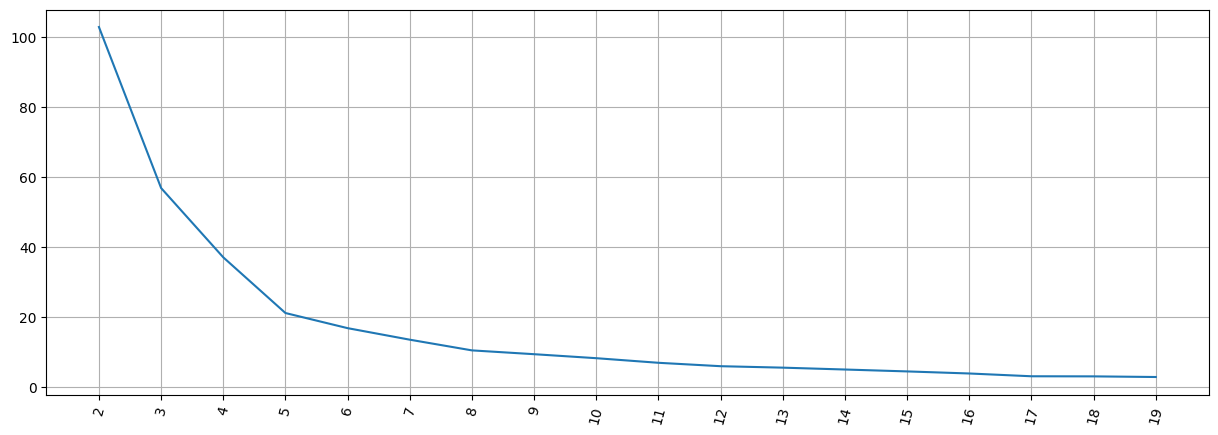

In [224]:
distorcions = []
max_loop = 20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distorcions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorcions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

distorsions = []


Silhoute Score, métrica que varia de -1 até 1, aonde 1 significa que os clusters estão perfeitamente separados.

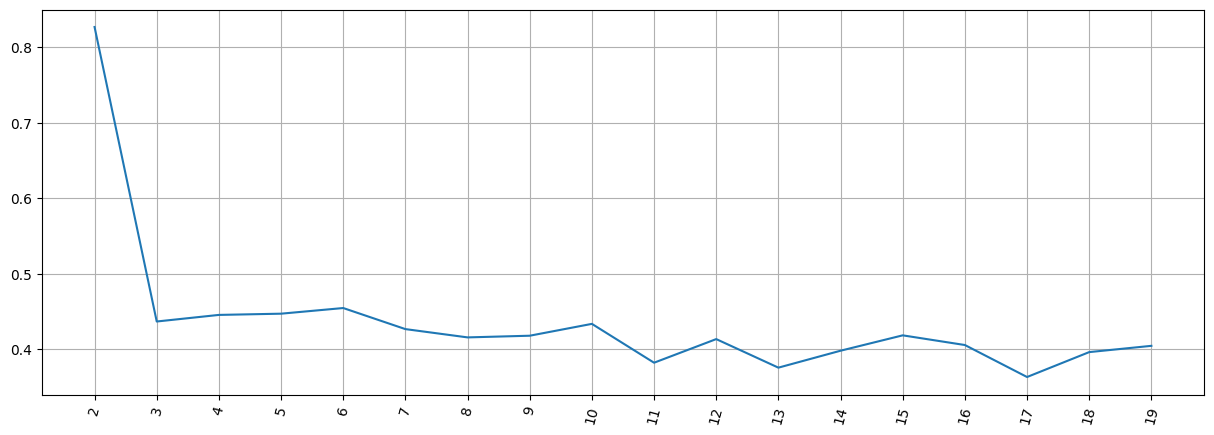

In [225]:
from sklearn import metrics

silhoutte_score = []
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
    kmeans.fit(X)
    silhoutte_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15,5))
plt.plot(range(2, max_loop), silhoutte_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid()

Pelas as análises do SSE e o SillhouteScore, foi escolhido o número de 4 clusters.

### Treinamento

In [226]:
nclust = 4
kmeans = KMeans(n_clusters=nclust, random_state=42)
kmeans.fit(X)

print("Clusters encontrados:", np.unique(kmeans.labels_))

Clusters encontrados: [0 1 2 3]


In [227]:
target_labels = kmeans.predict(X)

### Visualizando

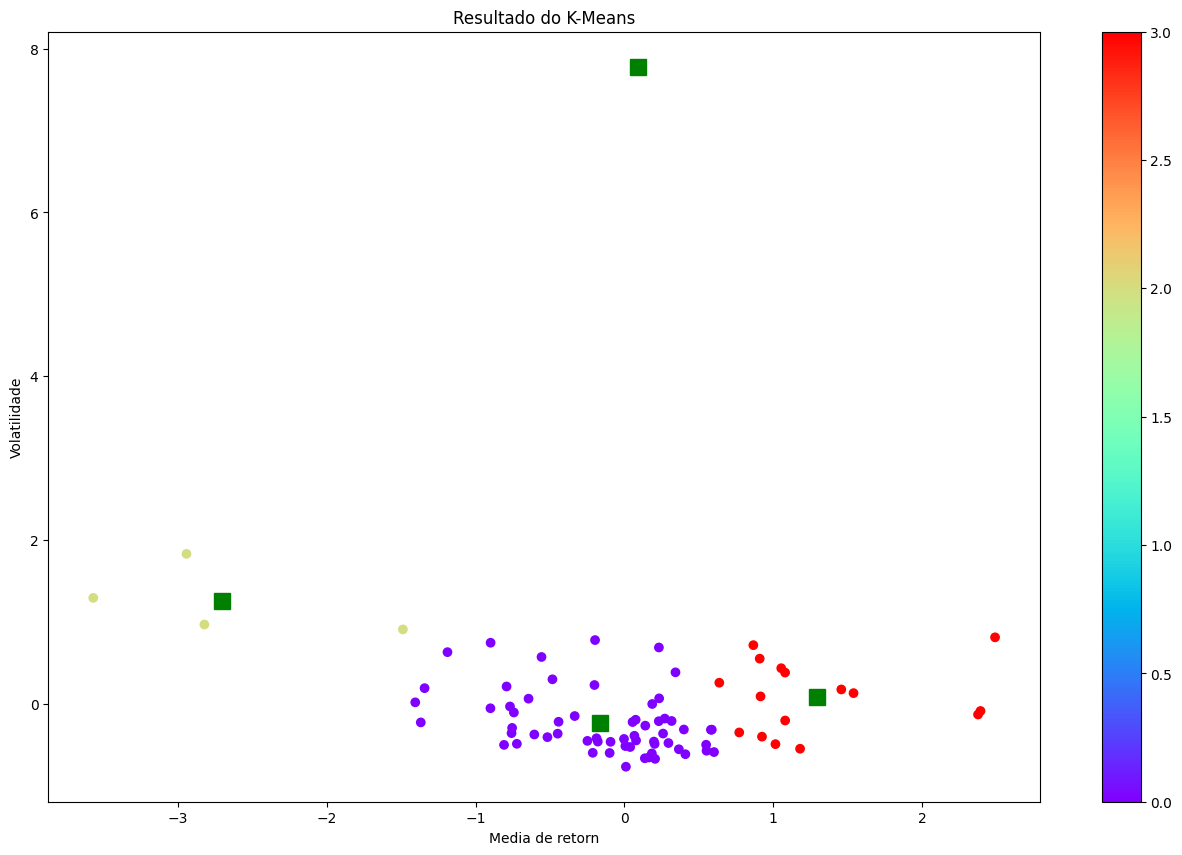

In [228]:
centroids = kmeans.cluster_centers_
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c = kmeans.labels_, cmap="rainbow", label = X.index)
ax.set_title("Resultado do K-Means")
ax.set_xlabel("Media de retorn")
ax.set_ylabel("Volatilidade")
plt.colorbar(scatter)

plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=11)

Volume por cluster

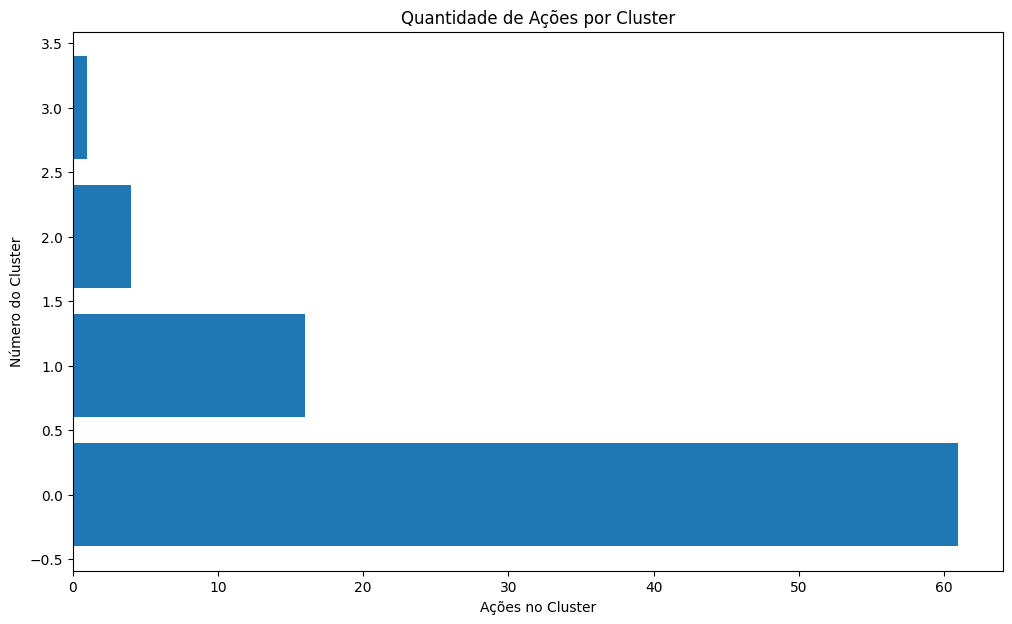

In [229]:
# mostrar o número de ações em cada cluster
clustered_series = pd.Series(index=X.index, data=kmeans.labels_.flatten())
# ações agrupadas com seus respectivos rótulos de cluster
clustered_series_all = pd.Series(index=X.index, data=kmeans.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12, 7))
plt.barh(
    range(len(clustered_series.value_counts())),  # rótulos dos clusters, eixo y
    clustered_series.value_counts()
)
plt.title('Quantidade de Ações por Cluster')
plt.xlabel('Ações no Cluster')
plt.ylabel('Número do Cluster')
plt.show()


### Agglomerative

Testando algoritmo Agglomerative

### Identificando o número ideal de clusters

In [230]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

Z = linkage(X, method='ward')
Z[0]

array([7.40000000e+01, 7.90000000e+01, 6.23491089e-03, 2.00000000e+00])

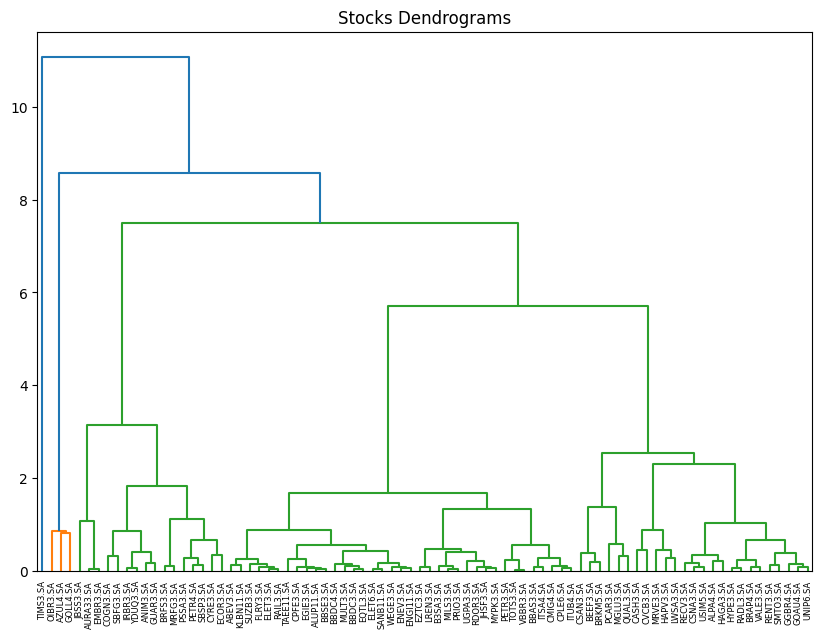

In [231]:
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.show()

O Eixo y do dendograma representa a distância ou dissimilaridade entre os clusters ou observações. (Ações neste caso)

Interpretação prática:

- Quanto maior o valor no eixo Y em que dois ramos são unidos, mais diferentes (menos semelhantes) são os clusters ou ações.

- Ramos unidos mais próximos da base (valores baixos de Y) indicam ações com comportamentos mais semelhantes.

In [232]:
distance_threshold = 3.8
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([3, 4, 2, 1, 5], dtype=int32)

### Treinamento

In [233]:
nclust = 5
hc = AgglomerativeClustering(n_clusters=nclust, metric= 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

### Visualizando

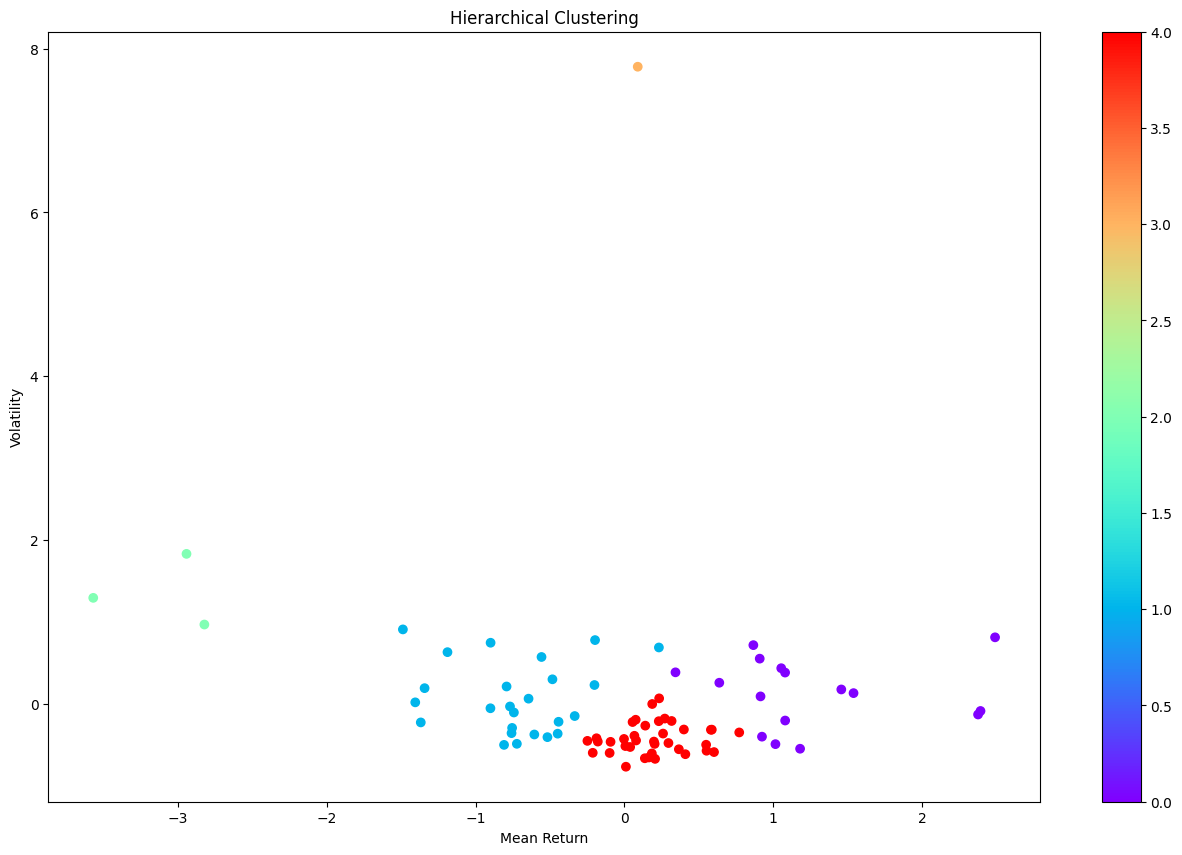

In [234]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

## Affinity Propagation

In [235]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

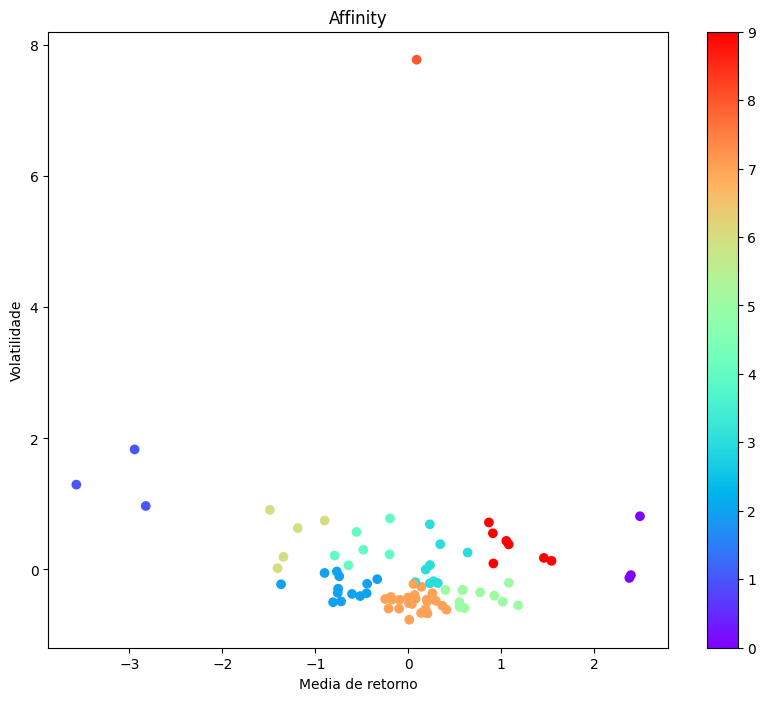

In [236]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Media de retorno')
ax.set_ylabel('Volatilidade')
plt.colorbar(scatter)

In [237]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

### Visualizando

Estimated number of clusters: 10


<Figure size 640x480 with 0 Axes>

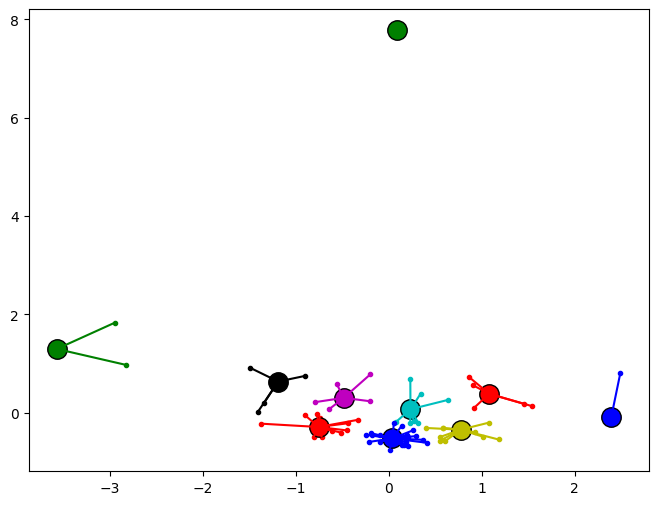

In [238]:
no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

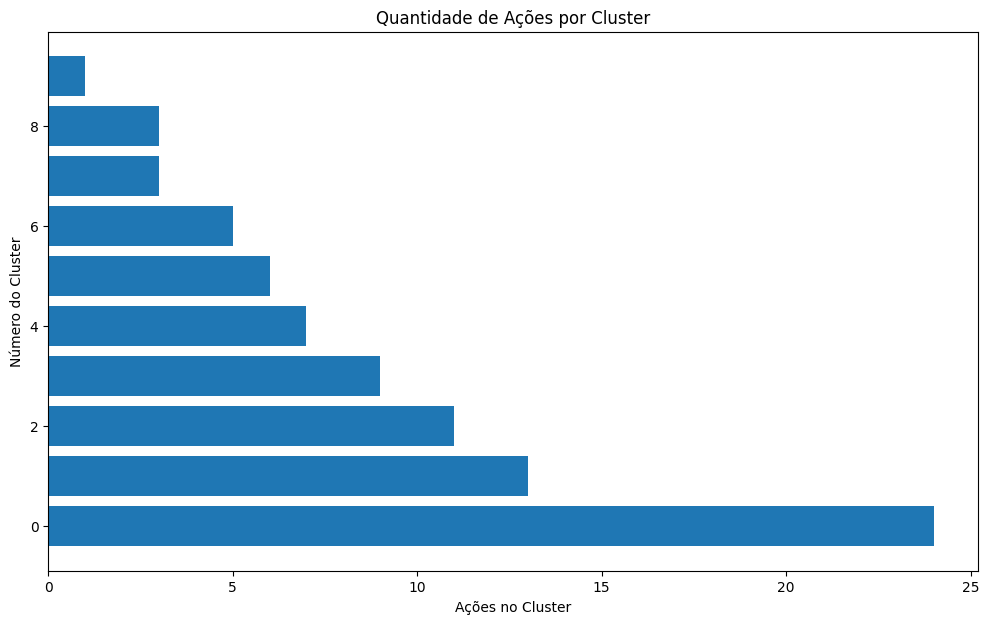

In [239]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Quantidade de Ações por Cluster')
plt.xlabel('Ações no Cluster')
plt.ylabel('Número do Cluster')
plt.show()

## Avaliação entre os modelos para escolher o melhor.

In [240]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.45453090550786024
hc 0.4435359918829607
ap 0.39459067973964257


## Analisando Clusters

- Visualizando o retorno dentro de um cluster. Já temos a técnica de clustering e o número de clusters definidos, mas precisamos verificar se o agrupamento resulta em uma saída sensata. Para fazer isso, visualizamos o comportamento histórico das ações em alguns clusters:

In [241]:
# todas as ações com seu rótulo de cluster (incluindo -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())

# ações agrupadas com seu rótulo de cluster
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())

# remove da série os pontos que foram classificados como -1 (ruído ou não atribuídos)
clustered_series = clustered_series[clustered_series != -1]

In [242]:
# obter o número de ações em cada cluster
counts = clustered_series_ap.value_counts()

#visualizar alguns clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[1, 0, 6, 4, 9, 3, 5, 2, 7]

In [243]:
# Tamanho máximo permitido para um cluster
CLUSTER_SIZE_LIMIT = 9999

# Conta quantos ativos (ações) há em cada cluster
counts = clustered_series.value_counts()

# Filtra clusters que têm mais de 1 ação e no máximo o limite definido
ticker_count_reduced = counts[(counts > 1) & (counts <= CLUSTER_SIZE_LIMIT)]

# Mostra quantos clusters válidos foram formados
print("Clusters formados: %d" % len(ticker_count_reduced))

# Calcula e mostra quantos pares de ações podem ser avaliados dentro desses clusters
print("Pares a serem avaliados: %d" % (ticker_count_reduced * (ticker_count_reduced - 1)).sum())


Clusters formados: 9
Pares a serem avaliados: 994


In [244]:
# plotar alguns dos menores clusters
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[1, 0, 6, 4]

<Figure size 1200x700 with 0 Axes>

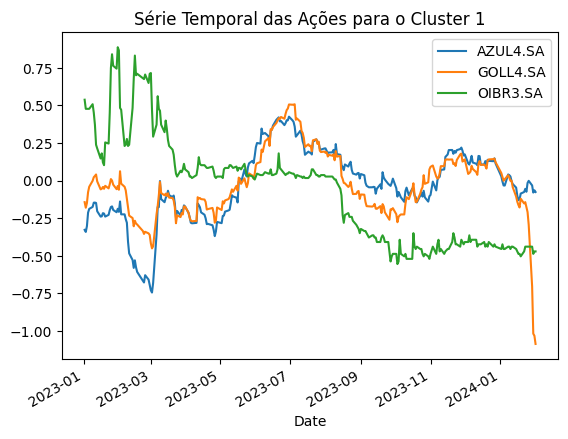

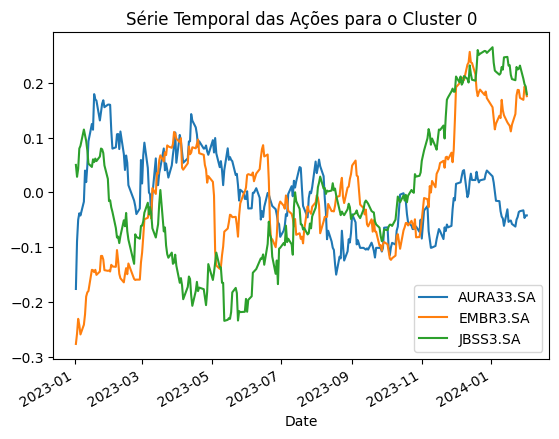

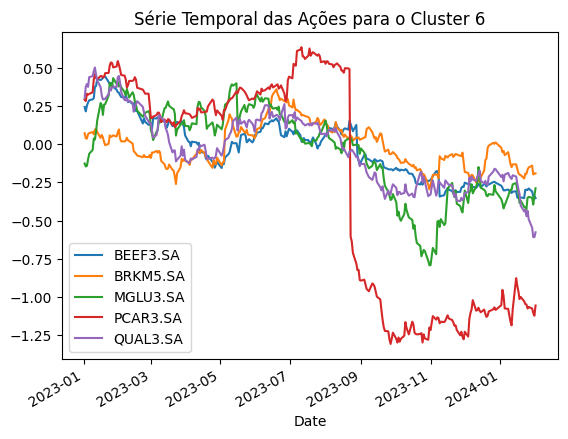

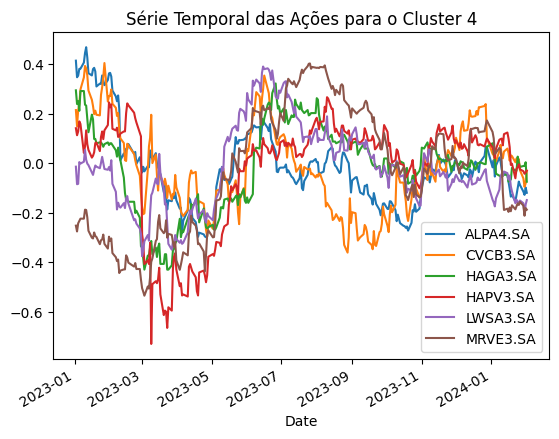

In [245]:
# Para cada cluster nos primeiros (no máximo 4) clusters da lista de visualização
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    # Pega os tickers (ações) que pertencem a esse cluster
    tickers = list(clustered_series[clustered_series == clust].index)
    
    # Calcula a média dos preços (logaritmo natural) até a data 2024-02-01
    means = np.log(dataset.loc[:"2024-02-01", tickers].mean())
    
    # Subtrai a média de cada série temporal (normalização centrada na média logarítmica)
    data = np.log(dataset.loc[:"2024-02-01", tickers]).sub(means)
    
    # Plota a série temporal das ações normalizadas para o cluster atual
    data.plot(title='Série Temporal das Ações para o Cluster %d' % clust)

# Exibe todos os gráficos
plt.show()


Analisando os gráficos acima, em todos os clusters com um pequeno número de ações, vemos um movimento similar das ações dentro de diferentes clusters, o que corrobora a eficácia da técnica de clustering.

## Seleção de pares

### Explicação simplificada :
Após a formação dos clusters (ou grupos de ações com comportamentos semelhantes), é possível aplicar métodos estatísticos para identificar quais pares de ações dentro de cada grupo realmente têm uma relação consistente ao longo do tempo. Isso é feito por meio de um conceito chamado cointegração.

🧠 O que é cointegração?
Mesmo que duas ações se movimentem bastante (sejam instáveis), elas podem ter uma tendência de andar juntas no longo prazo. Quando isso acontece, dizemos que essas séries de preços são cointegradas.

Detectar cointegração é fundamental no pairs trading, porque permite identificar pares de ações cujos preços divergem temporariamente, mas costumam voltar à relação histórica — o que gera oportunidades de lucro.

📊 Como testamos a cointegração?
Utilizamos testes estatísticos como:

ADF (Augmented Dickey-Fuller): verifica se a diferença entre os preços dos ativos é estável ao longo do tempo.

Teste de Johansen: identifica múltiplas relações de cointegração entre três ou mais ativos.

⚙️ O que o código faz nesta etapa?
Nesta parte do estudo:

Percorremos os ativos dentro de cada cluster.

Aplicamos os testes de cointegração entre os pares possíveis.

Guardamos os resultados em:

Uma matriz de pontuações dos testes,

Uma matriz de valores-p (indicando a significância dos resultados),

E uma lista dos pares cointegrados com valor-p menor que 0,05 (ou seja, com alta confiança estatística).

Esses pares são candidatos ideais para estratégias de pairs trading, pois apresentam forte evidência de que seus preços têm uma relação estável no longo prazo.



### Cointegration and pair selection function.

In [246]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

### Em seguida, verificamos a cointegração de diferentes pares dentro de vários clusters usando a função que criamos anteriormente, e então retornamos os pares encontrados.

In [247]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [248]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])
    

In [249]:
print("Número de pares encontrados: %d" % len(pairs))
print("Nesses pares, há %d tickers únicos." % len(np.unique(pairs)))


Número de pares encontrados: 7
Nesses pares, há 10 tickers únicos.


"Vamos visualizar os resultados do processo de seleção de pares agora. Consulte o notebook Jupyter deste estudo de caso para obter os detalhes das etapas relacionadas à visualização de pares usando a técnica t-SNE.

O gráfico a seguir mostra a força do K-Means para encontrar pares não tradicionais (apontados com uma seta na visualização). DXC é o símbolo de DXC Technology, e XEC é o símbolo de Cimarex Energy. Essas duas ações são de setores diferentes e, à primeira vista, parecem não ter nada em comum, mas foram identificadas como pares usando o clustering K-Means e o teste de cointegração. Isso implica que existe uma relação estável de longo prazo entre os movimentos de seus preços de ações"

*** REVISAR

In [250]:
pairs

[('BRAP4.SA', 'RADL3.SA'),
 ('ALPA4.SA', 'CVCB3.SA'),
 ('ALPA4.SA', 'HAPV3.SA'),
 ('ALPA4.SA', 'LWSA3.SA'),
 ('ALPA4.SA', 'MRVE3.SA'),
 ('BEEF3.SA', 'MGLU3.SA'),
 ('BEEF3.SA', 'QUAL3.SA')]

In [251]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [252]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [253]:
X_tsne = TSNE(learning_rate=50, perplexity=1, random_state=1337).fit_transform(X_pairs)


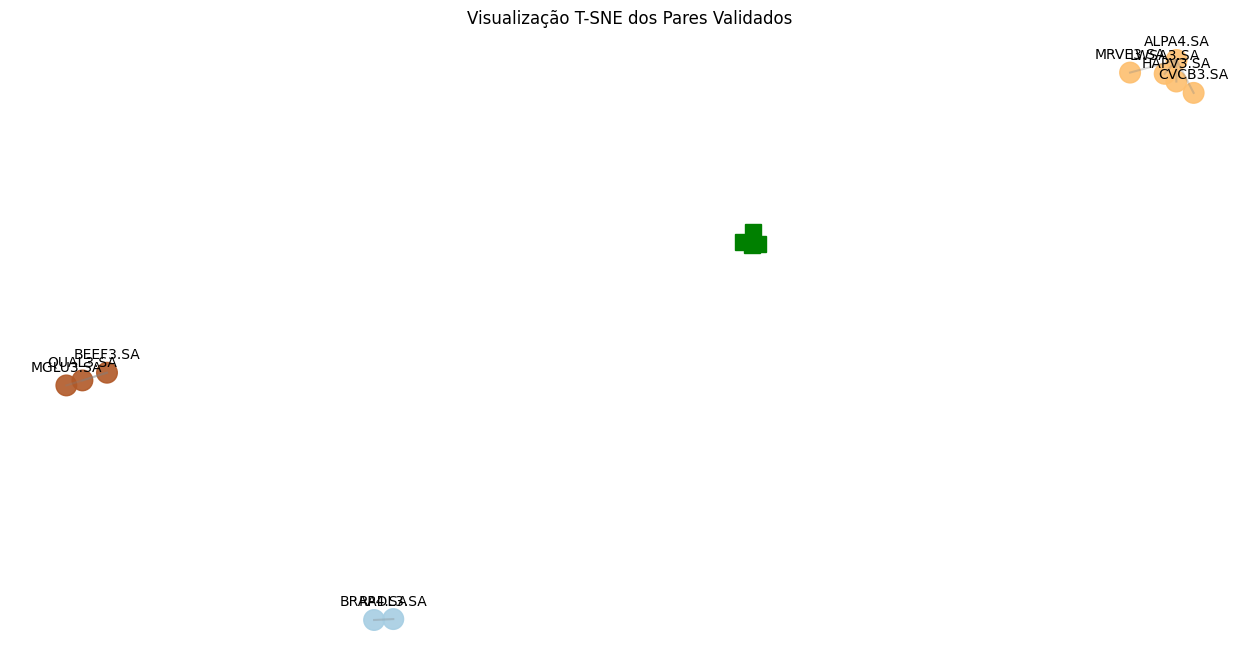

In [254]:
plt.figure(1, facecolor='white', figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    # print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    # print(ticker1, loc1)

    ticker2 = pair[1]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray')

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('Visualização T-SNE dos Pares Validados')

# zip junta as coordenadas x e y em pares
for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):

    label = name

    plt.annotate(label,            # este é o texto
                 (x, y),          # este é o ponto a ser rotulado
                 textcoords="offset points",  # como posicionar o texto
                 xytext=(0,10),   # distância do texto para o ponto (x,y)
                 ha='center')     # alinhamento horizontal: pode ser left, right ou center
    
plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=11)
